The SIR model for disease

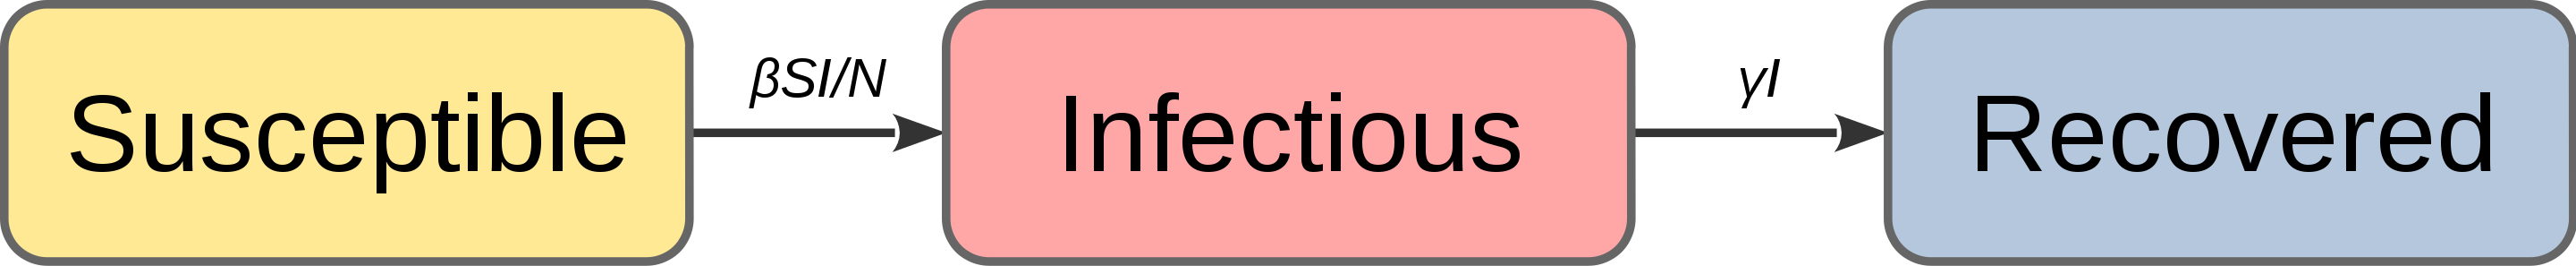

$$\begin{align}
\frac{\partial S}{\partial t} &= D_s \nabla^2 S -\beta \frac{S I}{N} \hspace{20mm}
\frac{\partial I}{\partial t} &= D_i \nabla^2 I + \beta \frac{S I}{N} - \gamma I \hspace{20mm}
\frac{\partial R}{\partial t} &= \gamma I.
\end{align}$$

Source: https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid2.ipynb

**TASK:** Simulate the spread of an infectious disease using the PDE version of the SIR model and explore the impact of transmission and recovery rates on spatial dynamics.

**GOVERNING EQUATIONS (Partial Differential Equations):**
- ∂S/∂t = D_s∇²S - β·S·I/N    (Susceptible: diffusion - infection)
- ∂I/∂t = D_i∇²I + β·S·I/N - γ·I    (Infected: diffusion + infection - recovery)
- ∂R/∂t = γ·I    (Recovered: only from infected)

 **Where:**
 - S, I, R: Population densities (individuals/cm²)
 - β: Transmission rate (day⁻¹)
 - γ: Recovery rate (day⁻¹)
 - N: Total population
 - D_s, D_i: Diffusion coefficients (cm²/day)
 - ∇²: Laplacian operator (second spatial derivative)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

**Typical Parameter Values**

- $D_s = 0.01 - 0.1$ cm²/day
- $D_i = 0.01 - 0.1$ cm²/day
- $\beta = 0.1 - 0.5$ day⁻¹
- $\gamma = 0.05 - 0.2$ day⁻¹
- $N = 1000 - 50000$ (total population)

In [3]:
# Reaction parameters
beta = 0.25      # transmission rate
gamma = 0.1     # recovery rate

# Diffusion parameters (corrected model: S and I diffuse)
Ds = 0.10       # Diffusion coefficient for Susceptible population (cm²/day)
                # Controls spatial mobility of susceptible individuals
                # Lower value → less movement, more localized
                # Typical range: 0.01 - 0.1 cm²/day

Di = 0.05       # Diffusion coefficient for Infected population (cm²/day)
                # Controls spatial mobility of infected individuals
                # Di > Ds means infected individuals move more
                # This can represent behavioral changes or active spread
                # Typical range: 0.01 - 0.1 cm²/day

# Domain / grid
Lx, Ly = 10.0, 10.0 # Total size of domain (cm)
nx, ny = 101, 101 # The grid density creates 100 discrete intervales
dx = Lx / (nx - 1) # Step size in x direction
dy = Ly / (ny - 1) # Step size in y direction

# Time
tmax = 365.0   # Total simulation time (days)

# Stability-constrained time step
# dt must be small enough to prevent numerical instability (oscillations, negative values)
# Formula based on diffusion stability criterion with 0.5 safety factor
Dmax = max(Ds, Di) # based on the diffusion limit
dt_max = 1.0 / (2.0 * Dmax * (1.0/dx**2 + 1.0/dy**2))
dt = 0.5 * dt_max  # safety factor
nt = int(np.ceil(tmax / dt))

(beta, gamma, Ds, Di, dx, dy, dt, nt)


(0.25, 0.1, 0.1, 0.05, 0.1, 0.1, 0.0125, 29200)

In [4]:
def apply_neumann_bc(u: np.ndarray) -> None:
    """
    Zero-flux Neumann boundary conditions: prevents flow across domain edges.
    Copies edge values to enforce zero spatial derivative (∂u/∂x = 0) at boundaries.
    This creates a closed system where population cannot enter/leave the domain.
    """
    u[0, :]  = u[1, :]
    u[-1, :] = u[-2, :]
    u[:, 0]  = u[:, 1]
    u[:, -1] = u[:, -2]

def laplacian_2d(u: np.ndarray, dx: float, dy: float) -> np.ndarray:
    """
    2D Laplacian using second-order central differences on a regular grid.
    Returns an array of same shape as u.
    """
    lap = np.zeros_like(u)
    lap[1:-1, 1:-1] = (
        (u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, :-2]) / dx**2
        + (u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[:-2, 1:-1]) / dy**2
    )
    return lap

def initial_conditions(nx: int, ny: int, Lx: float, Ly: float,
                       N0: float = 1.0, I0_peak: float = 0.02, sigma: float = 0.5):
    """
    Mostly susceptible, small Gaussian infected seed, no recovered initially.
    Ensures S + I + R = N0 pointwise initially.
    """
    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X, Y = np.meshgrid(x, y)

    cx, cy = Lx/2, Ly/2
    I = I0_peak * np.exp(-((X-cx)**2 + (Y-cy)**2) / (2*sigma**2))
    R = np.zeros_like(I)
    S = N0 - I - R

    return S, I, R, X, Y

S, I, R, X, Y = initial_conditions(nx, ny, Lx, Ly)
S.min(), I.max(), R.max()


def sir_step(S: np.ndarray, I: np.ndarray, R: np.ndarray,
             beta: float, gamma: float, Ds: float, Di: float,
             dx: float, dy: float, dt: float):
    """
    One explicit Forward Euler step for the 2D reaction–diffusion SIR PDE.
    """
    # Apply BCs to diffusing fields before computing Laplacians
    apply_neumann_bc(S)
    apply_neumann_bc(I)

    N = S + I + R

    # Reaction terms
    infection = beta * S * I / N
    recovery = gamma * I

    # Diffusion terms
    diffS = Ds * laplacian_2d(S, dx, dy)
    diffI = Di * laplacian_2d(I, dx, dy)

    # Update
    S_new = S + dt * (diffS - infection)
    I_new = I + dt * (diffI + infection - recovery)
    R_new = R + dt * (recovery)

    # Optional: enforce non-negativity (helps prevent tiny negative values)
    S_new = np.clip(S_new, 0.0, None)
    I_new = np.clip(I_new, 0.0, None)
    R_new = np.clip(R_new, 0.0, None)

    return S_new, I_new, R_new

In [5]:
def run_simulation(S, I, R,
                   beta, gamma, Ds, Di,
                   dx, dy, dt, nt,
                   store_every: int = 50,
                   scenarios: list = None):
    """
    Time loop. Stores snapshots every `store_every` steps.
    
    If scenarios is provided, runs multiple simulations with different beta/gamma values.
    Otherwise, runs a single simulation with the provided beta/gamma.
    
    Parameters:
    -----------
    scenarios : list of dict, optional
        List of scenario dictionaries with keys 'beta', 'gamma', 'label'
        If None, runs single simulation with provided beta, gamma
    
    Returns:
    --------
    If scenarios is None:
        times : array, snapshots : list
    If scenarios is provided:
        results : list of dicts with keys 'label', 'beta', 'gamma', 'times', 'snapshots'
    """
    
    # Single simulation mode
    if scenarios is None:
        snapshots = []
        times = []

        for n in tqdm(range(nt + 1), desc="Simulating"):
            if n % store_every == 0:
                snapshots.append((S.copy(), I.copy(), R.copy()))
                times.append(n * dt)

            S, I, R = sir_step(S, I, R, beta, gamma, Ds, Di, dx, dy, dt)

        return np.array(times), snapshots
    
    # Multiple scenarios mode
    else:
        results = []
        
        for scenario in scenarios:
            print(f"\nRunning: {scenario['label']}")
            
            # Reset to initial conditions
            S_current = S.copy()
            I_current = I.copy()
            R_current = R.copy()
            
            snapshots = []
            times = []
            
            for n in tqdm(range(nt + 1), desc=scenario['label']):
                if n % store_every == 0:
                    snapshots.append((S_current.copy(), I_current.copy(), R_current.copy()))
                    times.append(n * dt)

                S_current, I_current, R_current = sir_step(
                    S_current, I_current, R_current,
                    scenario['beta'], scenario['gamma'], Ds, Di,
                    dx, dy, dt
                )
            
            results.append({
                "label": scenario["label"],
                "beta": scenario["beta"],
                "gamma": scenario["gamma"],
                "times": np.array(times),
                "snapshots": snapshots
            })
        
        return results

In [6]:
# Single simulation (original behavior)
times, snapshots = run_simulation(S, I, R, beta, gamma, Ds, Di, dx, dy, dt, nt, store_every=50)

# Multiple scenarios
# 1. Low β, Low γ: Slow spread, slow recovery
# 2. High β, Low γ: Fast spread, slow recovery (worst case)
# 3. Low β, High γ: Slow spread, fast recovery (best case)
# 4. High β, High γ: Fast spread, fast recovery (moderate case)
scenarios = [
    {"beta": 0.1, "gamma": 0.05, "label": "β=0.1, γ=0.05"},
    {"beta": 0.5, "gamma": 0.05, "label": "β=0.5, γ=0.05"},
    {"beta": 0.1, "gamma": 0.2, "label": "β=0.1, γ=0.2"},
    {"beta": 0.5, "gamma": 0.2, "label": "β=0.5, γ=0.2"},
]

results = run_simulation(S, I, R, None, None, Ds, Di, dx, dy, dt, nt, 
                        store_every=50, scenarios=scenarios)

# Access individual results
for result in results:
    print(f"{result['label']}: {len(result['snapshots'])} snapshots")

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]


Running: β=0.1, γ=0.05


β=0.1, γ=0.05:   0%|          | 0/29201 [00:00<?, ?it/s]


Running: β=0.5, γ=0.05


β=0.5, γ=0.05:   0%|          | 0/29201 [00:00<?, ?it/s]


Running: β=0.1, γ=0.2


β=0.1, γ=0.2:   0%|          | 0/29201 [00:00<?, ?it/s]


Running: β=0.5, γ=0.2


β=0.5, γ=0.2:   0%|          | 0/29201 [00:00<?, ?it/s]

β=0.1, γ=0.05: 585 snapshots
β=0.5, γ=0.05: 585 snapshots
β=0.1, γ=0.2: 585 snapshots
β=0.5, γ=0.2: 585 snapshots


In [7]:
def totals_over_time(times, snapshots, dx, dy):
    """
    Calculate total population in each compartment over time by integrating over the spatial domain.
    
    Parameters:
    -----------
    times : array
        Time points
    snapshots : list of tuples
        List of (S, I, R) arrays at each time point
    dx, dy : float
        Spatial grid spacing
    
    Returns:
    --------
    S_tot, I_tot, R_tot : arrays
        Total population in each compartment over time
    """
    area = dx * dy
    S_tot = []
    I_tot = []
    R_tot = []
    
    for (S, I, R) in snapshots:
        S_tot.append(S.sum() * area)
        I_tot.append(I.sum() * area)
        R_tot.append(R.sum() * area)
    
    return np.array(S_tot), np.array(I_tot), np.array(R_tot)

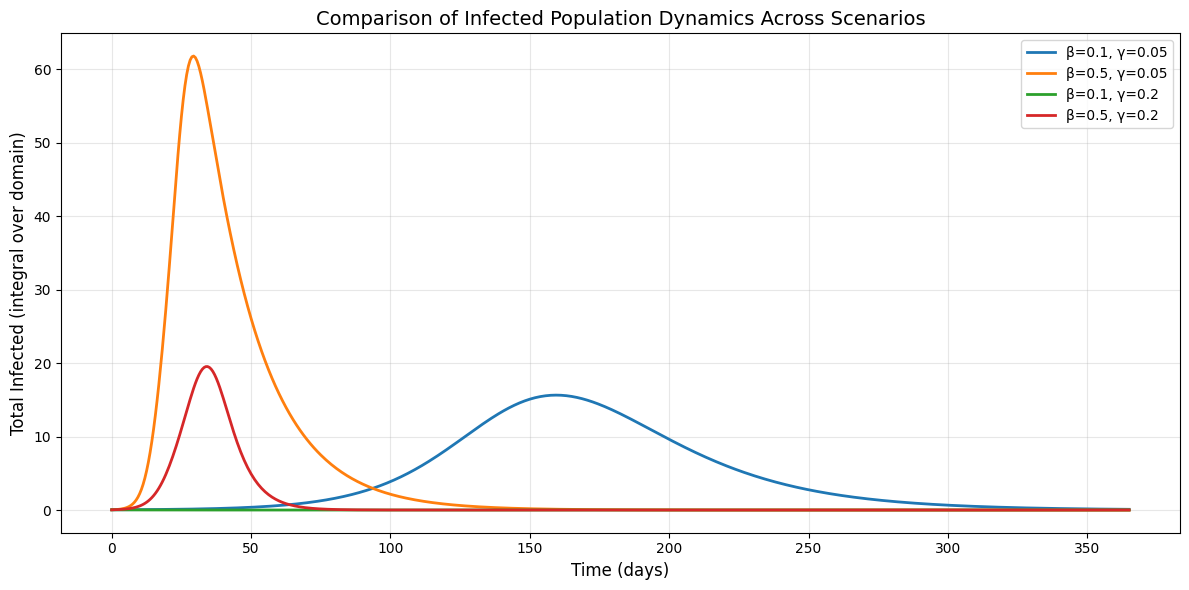

In [8]:
# Comparison plot: Total infected over time for all scenarios
plt.figure(figsize=(12, 6))
for result in results:
    S_tot, I_tot, R_tot = totals_over_time(result["times"], result["snapshots"], dx, dy)
    plt.plot(result["times"], I_tot, label=result["label"], linewidth=2)

plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Total Infected (integral over domain)", fontsize=12)
plt.title("Comparison of Infected Population Dynamics Across Scenarios", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

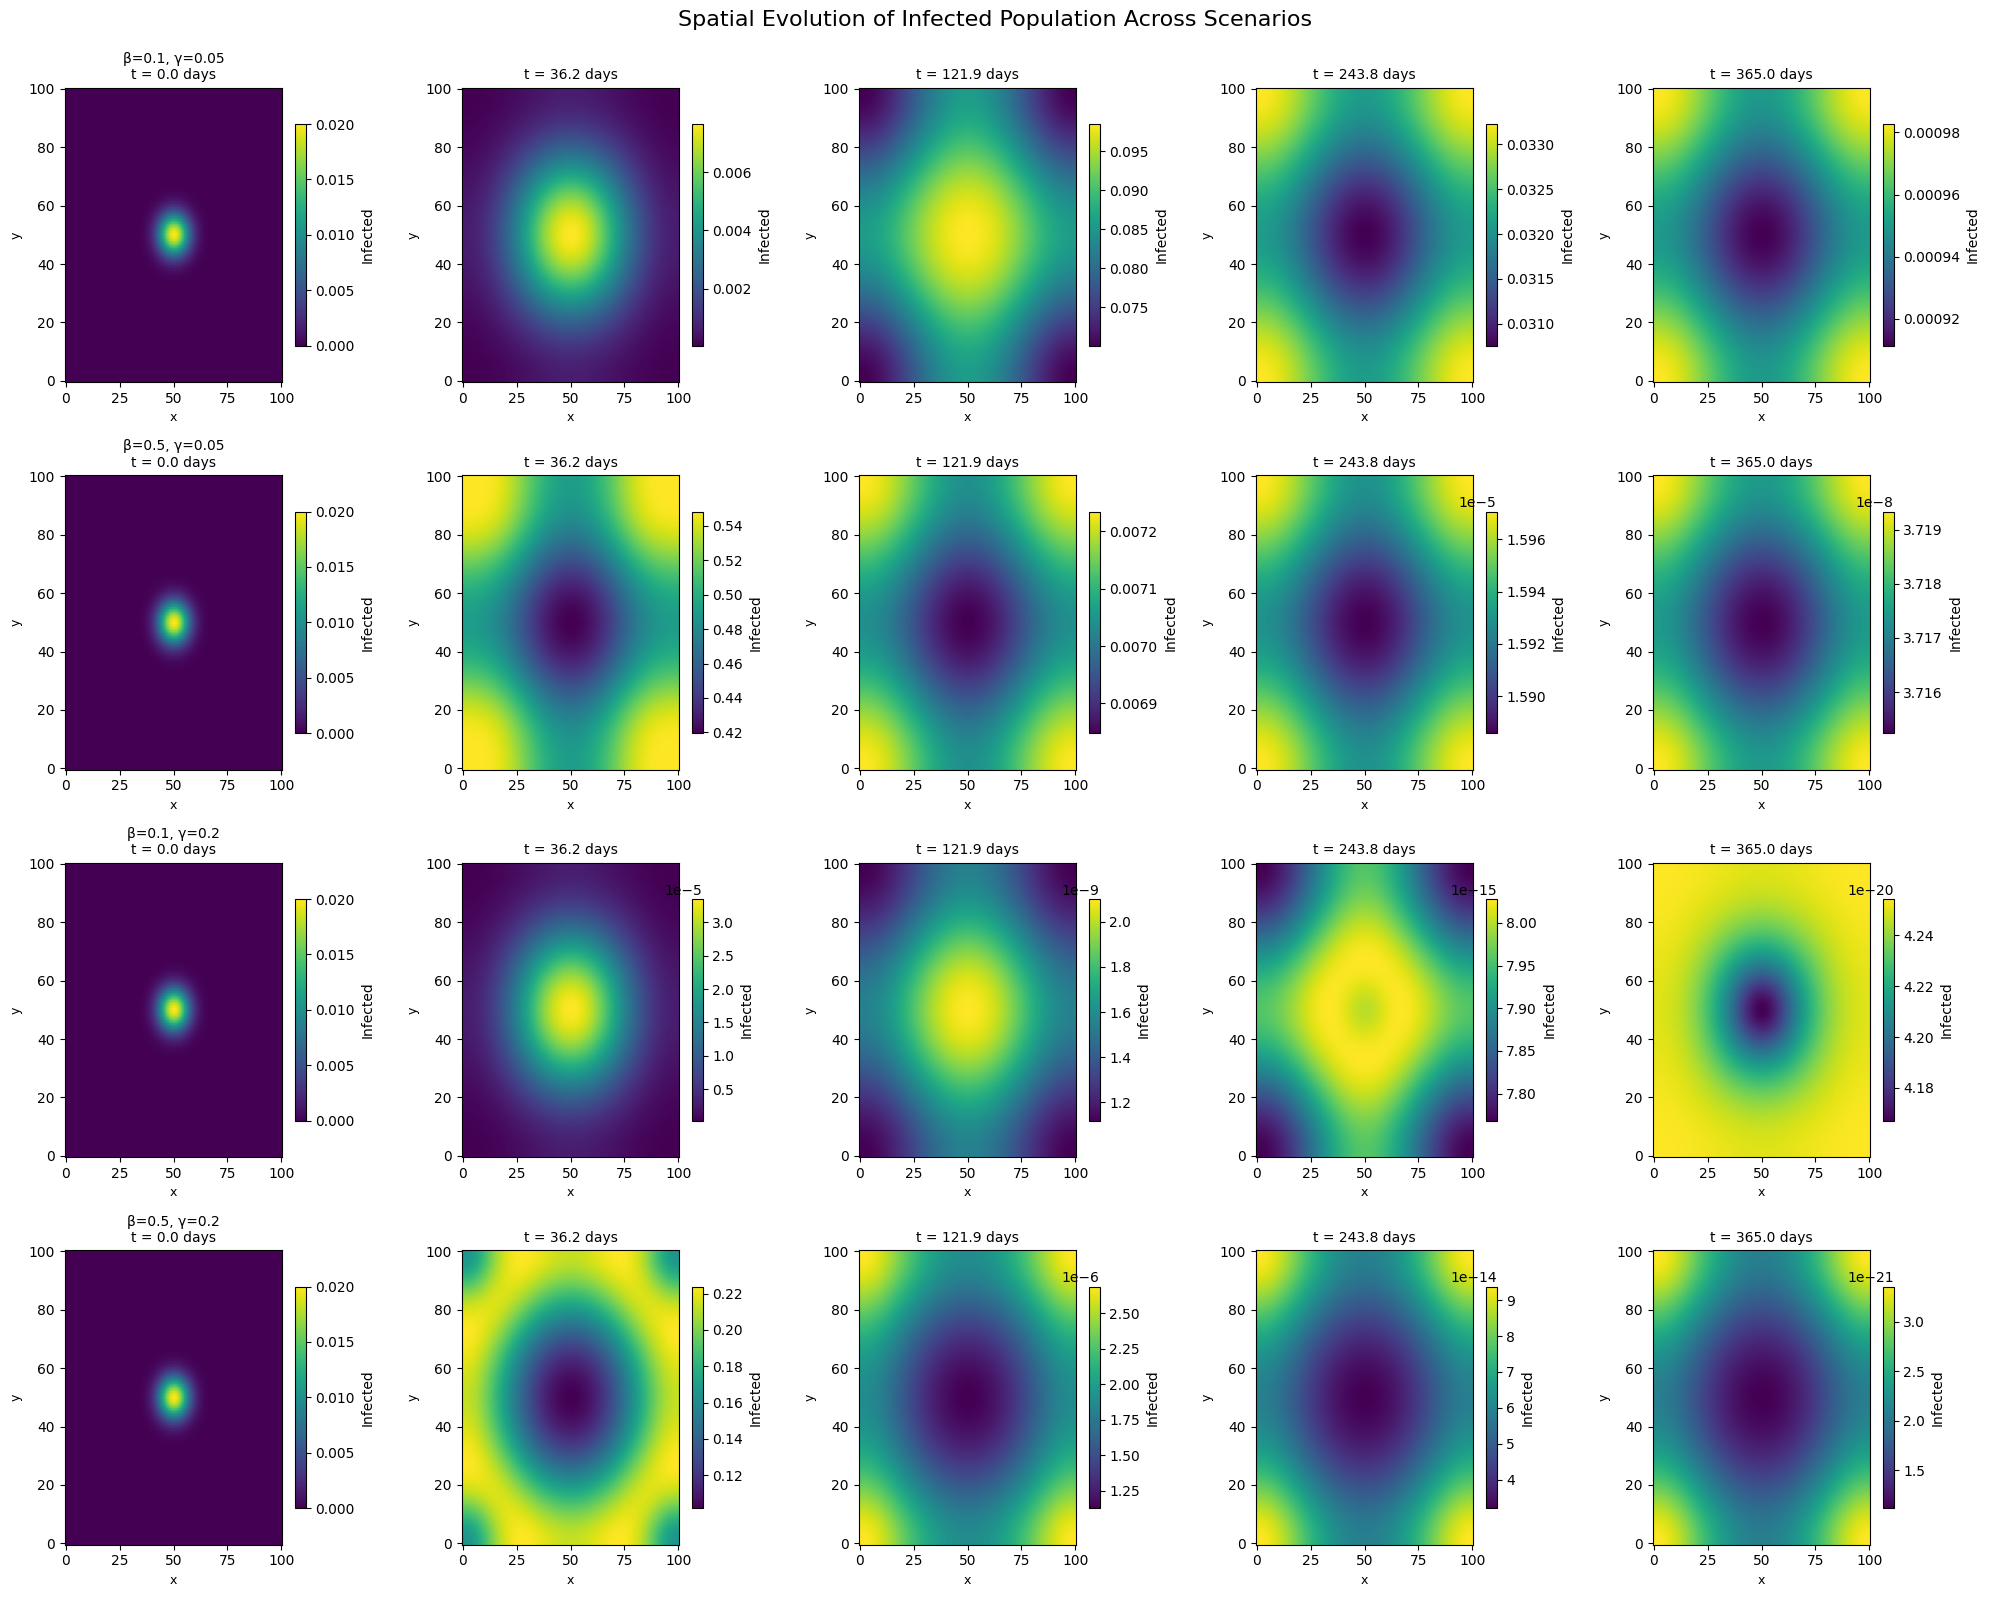

In [9]:
# Spatial snapshots at selected time points for all scenarios
# Define time indices to display
idxs = [0, len(results[0]["times"])//10, len(results[0]["times"])//3, 
        2*len(results[0]["times"])//3, len(results[0]["times"])-1]

# Create figure: rows = scenarios, columns = time points
n_scenarios = len(results)
n_times = len(idxs)

fig, axes = plt.subplots(n_scenarios, n_times, figsize=(4*n_times, 4*n_scenarios))

# If only one scenario, axes won't be 2D, so fix it
if n_scenarios == 1:
    axes = axes.reshape(1, -1)

# Plot each scenario (row) at each time point (column)
for row_idx, result in enumerate(results):
    for col_idx, time_idx in enumerate(idxs):
        _, I_snapshot, _ = result["snapshots"][time_idx]
        
        im = axes[row_idx, col_idx].imshow(I_snapshot, origin="lower", 
                                           aspect="auto", cmap="viridis")
        
        # Title: scenario label on first column, time on all columns
        if col_idx == 0:
            title = f"{result['label']}\nt = {result['times'][time_idx]:.1f} days"
        else:
            title = f"t = {result['times'][time_idx]:.1f} days"
        
        axes[row_idx, col_idx].set_title(title, fontsize=10)
        axes[row_idx, col_idx].set_xlabel("x", fontsize=9)
        axes[row_idx, col_idx].set_ylabel("y", fontsize=9)
        
        # Add colorbar to each subplot
        plt.colorbar(im, ax=axes[row_idx, col_idx], label="Infected", fraction=0.046)

plt.suptitle("Spatial Evolution of Infected Population Across Scenarios", 
             fontsize=16, y=0.995)
plt.tight_layout()
plt.show()


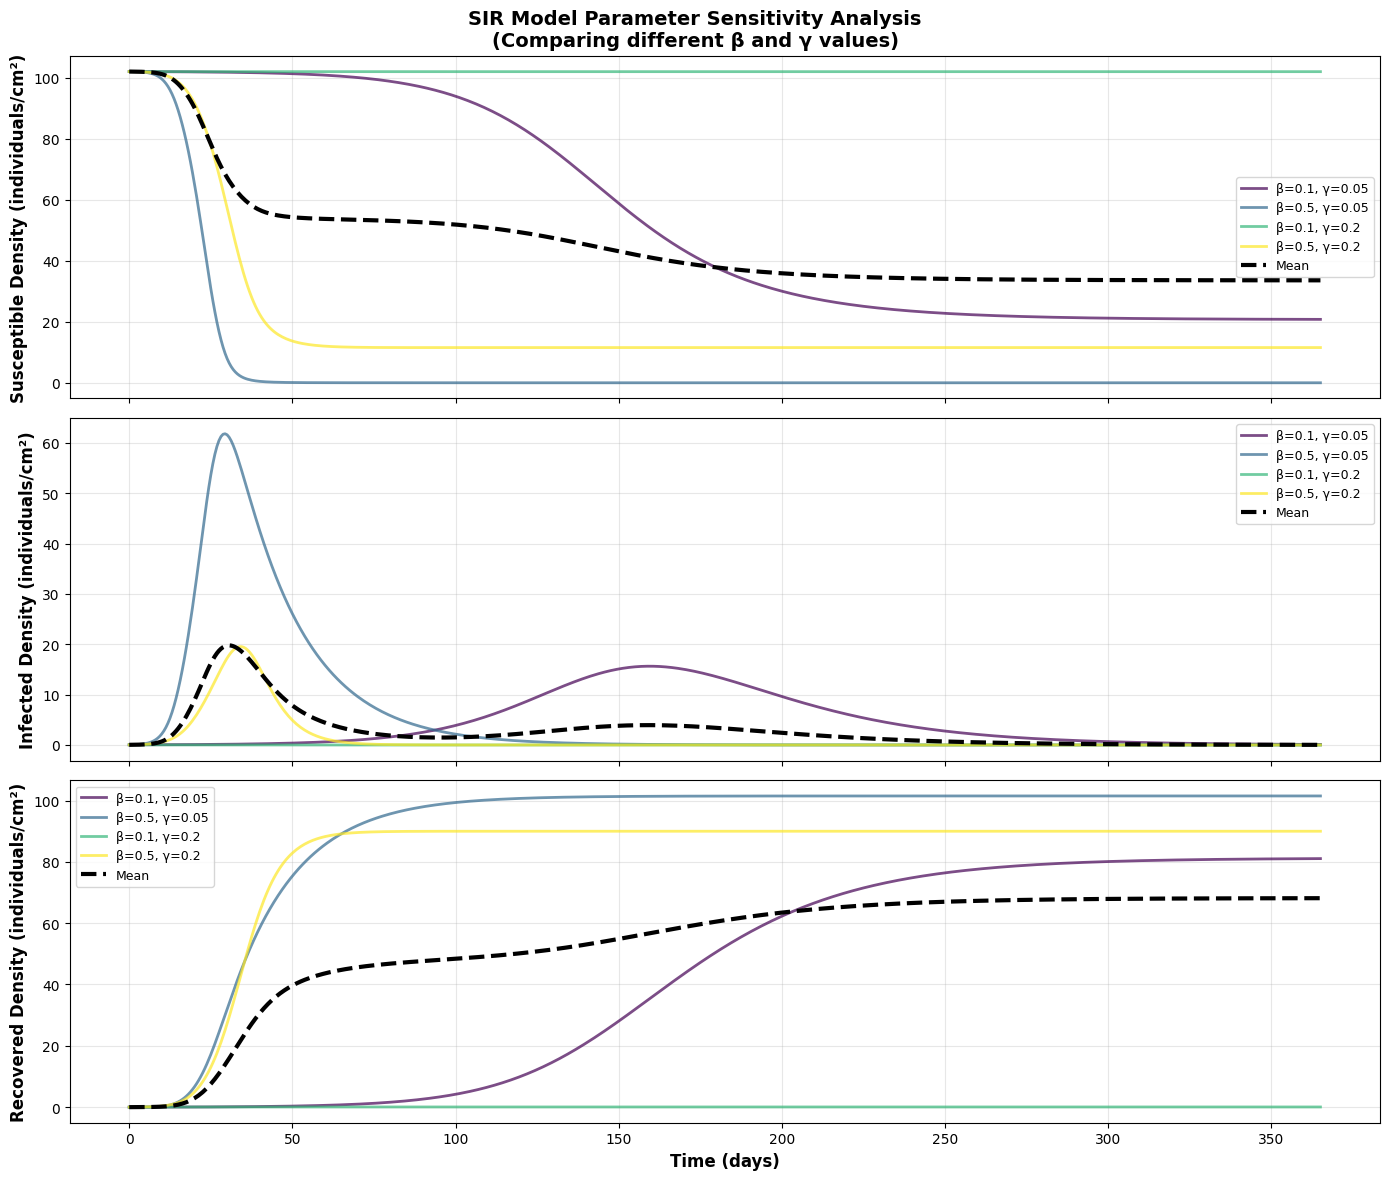

In [10]:
# =============================================================================
# SENSITIVITY ANALYSIS STYLE PLOT WITH LABELED TRAJECTORIES
# =============================================================================
fig, axes = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(14, 12))

# Collect all trajectories for each compartment
all_S = []
all_I = []
all_R = []

for result in results:
    S_tot, I_tot, R_tot = totals_over_time(result["times"], result["snapshots"], dx, dy)
    all_S.append(S_tot)
    all_I.append(I_tot)
    all_R.append(R_tot)

# Convert to numpy arrays: shape = (n_scenarios, n_timepoints)
all_S = np.array(all_S)
all_I = np.array(all_I)
all_R = np.array(all_R)
times = results[0]["times"]

# Define colors for each scenario
colors = plt.cm.viridis(np.linspace(0, 1, len(results)))

# Plot S (Susceptible)
for i, result in enumerate(results):
    axes[0].plot(times, all_S[i], color=colors[i], alpha=0.7, linewidth=2, 
                label=result["label"])
S_mean = np.mean(all_S, axis=0)
axes[0].plot(times, S_mean, color='black', linewidth=3, linestyle='--', 
            label='Mean', zorder=10)
axes[0].set_ylabel("Susceptible Density (individuals/cm²)", fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9, loc='best')
axes[0].grid(True, alpha=0.3)

# Plot I (Infected)
for i, result in enumerate(results):
    axes[1].plot(times, all_I[i], color=colors[i], alpha=0.7, linewidth=2, 
                label=result["label"])
I_mean = np.mean(all_I, axis=0)
axes[1].plot(times, I_mean, color='black', linewidth=3, linestyle='--', 
            label='Mean', zorder=10)
axes[1].set_ylabel("Infected Density (individuals/cm²)", fontsize=12, fontweight='bold')
axes[1].legend(fontsize=9, loc='best')
axes[1].grid(True, alpha=0.3)

# Plot R (Recovered)
for i, result in enumerate(results):
    axes[2].plot(times, all_R[i], color=colors[i], alpha=0.7, linewidth=2, 
                label=result["label"])
R_mean = np.mean(all_R, axis=0)
axes[2].plot(times, R_mean, color='black', linewidth=3, linestyle='--', 
            label='Mean', zorder=10)
axes[2].set_ylabel("Recovered Density (individuals/cm²)", fontsize=12, fontweight='bold')
axes[2].set_xlabel("Time (days)", fontsize=12, fontweight='bold')
axes[2].legend(fontsize=9, loc='best')
axes[2].grid(True, alpha=0.3)

plt.suptitle("SIR Model Parameter Sensitivity Analysis\n(Comparing different β and γ values)", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Not sure if we should keep it


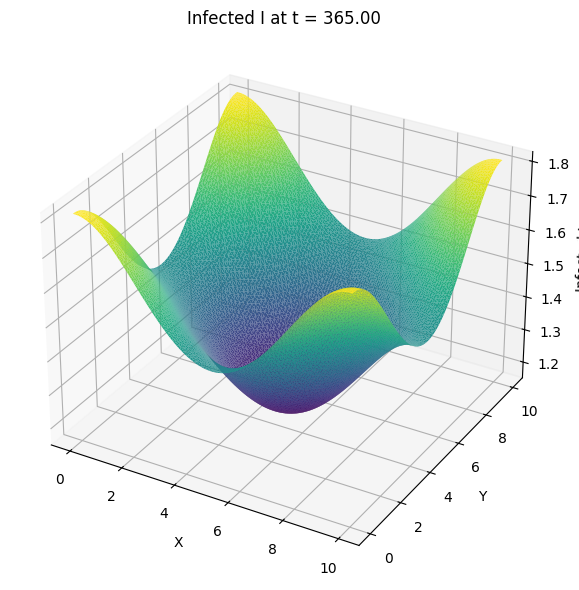

In [11]:
# Create 3d plot of infected population

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
X_flat = X.flatten()
Y_flat = Y.flatten()
I_k = snapshots[-1][1]
I_flat = I_k.flatten()
ax.plot_trisurf(X_flat, Y_flat, I_flat, cmap='viridis', edgecolor='none')
ax.set_title(f'Infected I at t = {times[-1]:.2f}')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Infected I')
plt.tight_layout()
plt.show()

In [26]:
import plotly.graph_objects as go

# Define ranges for beta and gamma
beta_range = np.linspace(0.1, 0.5, 20)   # Transmission rate range
gamma_range = np.linspace(0.05, 0.2, 20)  # Recovery rate range

# Create meshgrid for beta and gamma
beta_grid, gamma_grid = np.meshgrid(beta_range, gamma_range)

# Select time point to analyze (choose an appropriate snapshot index)
snapshot_idx = len(times) // 2  # Middle of simulation

# Initialize result array for peak infected values
Z = np.zeros_like(beta_grid)

# Run simulation for each combination of beta and gamma
for i in tqdm(range(len(gamma_range)), desc="Gamma loop"):
    for j in range(len(beta_range)):
        # Reset initial conditions
        S_temp, I_temp, R_temp, _, _ = initial_conditions(nx, ny, Lx, Ly)
        
        # Run simulation with current beta, gamma values
        times_temp, snapshots_temp = run_simulation(
            S_temp, I_temp, R_temp,
            beta_range[j], gamma_range[i], Ds, Di,  # Use current beta, gamma
            dx, dy, dt, nt,
            store_every=store_every
        )
        
        # Extract infected at snapshot_idx and get maximum value
        _, I_snapshot, _ = snapshots_temp[snapshot_idx]
        Z[i, j] = I_snapshot.max()

# Create 3D surface plot
fig = go.Figure(data=[go.Surface(
    z=Z,
    x=beta_grid,
    y=gamma_grid,
    colorscale='Viridis',
    opacity=0.9,
    showscale=True
)])

# Set axis titles
fig.update_layout(
    title=f"Maximum Infected vs. β and γ (t = {times[snapshot_idx]:.1f} days)",
    scene=dict(
        xaxis_title="β (transmission rate, day⁻¹)",
        yaxis_title="γ (recovery rate, day⁻¹)",
        zaxis_title="Max Infected Density",
    ),
    width=900,
    height=700,
    margin=dict(l=50, r=50, b=50, t=100)
)

fig.show()

Gamma loop:   0%|          | 0/20 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

Simulating:   0%|          | 0/29201 [00:00<?, ?it/s]

KeyboardInterrupt: 